In [31]:
import sys
sys.path.append('..')

import os
from sqlalchemy import create_engine, text
import geopandas as gpd
import pandas as pd
from geopandas.tools import sjoin
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely import wkb
import simplekml

from utilities_amigocloud import AmigocloudFunctions

In [32]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import API_AMIGOCLOUD_TOKEN_ADM
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [33]:
API_AMIGOCLOUD_TOKEN_ADM

'A:cf5xrxU3HgHj9FkLMiY5wW9LBFmvYDQG2TQ5FY'

In [106]:
# leer los dos shps de siembra y puntos de planificacion
PATH_SIEMBRA = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\SIEMBRAS.shp'
PATH_CAT = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\CATASTRO_S09_MIERCOLES.shp'
PATH_KML = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\KML_PLAN'

gdf_siembras = gpd.read_file(PATH_SIEMBRA)
gdf_cat = gpd.read_file(PATH_CAT)

In [75]:
PATH_SIEMBRA

'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - EQUIPO AVIACION UTEA\\Trichogramma\\2025\\SHP\\SIEMBRAS_.shp'

In [107]:
def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

def obtener_planificacion_no_procesado():
    engine = obtener_engine()
    try:
        query = """
            SELECT id_os, geom, cod_ca, nom_ca, obs, procesado, producto, dosis
            FROM drones_control_bio.planificacion_ctrl_bio
            WHERE procesado=false;
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

def obtener_parte_diario_por_id_os(id_os):
    engine = obtener_engine()
    try:
        query = f"""
            SELECT * FROM drones_control_bio.parte_diario_ctrl_bio where os = {id_os}
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

def filtrar_os_y_quitar_caracteres(gdf, ors):
    # filtrar la semana de interes
    gdf_puntos_select = gdf[gdf['id_os'] == ors]
    gdf_puntos_sem = gdf_puntos_select.copy()
    #quita caracteres especiales
    gdf_puntos_sem['nom_ca'] = gdf_puntos_sem['nom_ca'].str.replace(r'[\r\n\t]', '', regex=True)
    return gdf_puntos_sem

def marcar_como_procesado(id_os):
    engine = obtener_engine()  # tu función que crea el engine
    try:
        with engine.begin() as conn:
            query = text("""
                UPDATE drones_control_bio.planificacion_ctrl_bio
                SET procesado = true
                WHERE id_os = :id_os
            """)
            conn.execute(query, {"id_os": id_os})
            print(f"✔️ id_os {id_os} marcado como procesado.")
    except Exception as e:
        print(f"❌ Error al actualizar: {e}")
    return None

def crear_puntos_individuales(gdf):
    # Crear una lista para almacenar los nuevos registros de puntos individuales
    point_records = []
    # Iterar sobre cada registro en el GeoDataFrame original
    for idx, row in gdf.iterrows():
        multipoint_geom = row.geom
        # Verificar si la geometría es de tipo multipunto
        if isinstance(multipoint_geom, MultiPoint):
            for point in multipoint_geom.geoms:
                # Crear un nuevo registro para cada punto individual
                new_record = row.copy()
                new_record.geometry = point
                point_records.append(new_record)
        else:
            # Si la geometría ya es un punto, simplemente añadir el registro original
            point_records.append(row)
    
    # Crear un nuevo GeoDataFrame con los registros de puntos individuales
    puntos_indi = gpd.GeoDataFrame(point_records, geometry='geom', crs=gdf.crs)
    return puntos_indi

def definir_lotes_solicitud(gdf_puntos_indi):
    # Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono de siembra
    puntos_indi_solicitado = gdf_puntos_indi[~gdf_puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]
    
    # identifoca los lotes que se intersectan
    gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')    
    
    # filtra los lotes intersectados en la capa original
    poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
    
    # copy
    poligonos_intersect_cat = poligonos_intersect_cat.copy()
    poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]
    # Cambiar el nombre de la columna 'old_name' a 'new_name'
    poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)
    # CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
    # Iterar sobre cada punto y encontrar el polígono que intersecta
    for idx, point in puntos_indi_solicitado.iterrows():
        point_geom = point.geom
        matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
        # Actualizar los campos de los polígonos que intersectan con los valores del punto
        for poly_idx in matching_polygons.index:
            poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['cod_ca']
            poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['nom_ca']
    # agrega los campos faltantes
    poligonos_intersect_cat['fecha_ini'] = ''
    poligonos_intersect_cat['origen'] = 'SOLICITUD'
    poligonos_intersect_cat['dias'] = 0
    poligonos_intersect_cat['fecha'] = ''
    poligonos_intersect_cat['os'] = ors
    return poligonos_intersect_cat

def definir_lotes_siembra(gdf_puntos_indi):
    # SELECCIONAR LOS LOTES DE SIEMBRAS
    # identifoca los lotes que se intersectan
    gdf_lotes_siem = gpd.sjoin(gdf_siembras, gdf_puntos_indi, how='inner', predicate='intersects')
    # filtra los lotes intersectados en la capa original
    poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
    # copy
    poligonos_intersect_siem = poligonos_intersect_siem.copy()
    # agregar campo de semana_planificacion
    poligonos_intersect_siem['os'] = ors
    # crea el campo soca, y coloca 0 o 1 dependiendo del origen
    poligonos_intersect_siem['soca'] = poligonos_intersect_siem['origen'].apply(lambda x: 1 if 'SIEMBRA 2023' in x else 0)
    # ordena los campos
    poligonos_intersect_siem = poligonos_intersect_siem[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area',
           'fecha_ini', 'origen', 'dias', 'fecha', 'prioridad', 'inst', 'geometry', 'os', 'soca']]
    return poligonos_intersect_siem

def agregar_campos_faltantes(gdf_plan):
    gdf_plan['producto'] = ''
    gdf_plan['dosis'] = 0.0
    gdf_plan['id_labor'] = ''
    gdf_plan['fecha'] = ''
    gdf_plan['semana'] = 0
    gdf_plan['num_lib'] = 0
    gdf_plan['hora_ini'] = ''
    gdf_plan['hora_fin'] = ''
    gdf_plan['temp'] = 0
    gdf_plan['viento'] = 0
    gdf_plan['humedad'] = 0
    gdf_plan['cod_dron'] = ''
    gdf_plan['piloto_1'] = ''
    gdf_plan['piloto_2'] = ''
    gdf_plan['obs'] = ''
    gdf_plan['id_log'] = 0
    return gdf_plan

def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

def cargar_a_amigocloud(gdf):
    # repreyectar a WGS84
    gdf_pla_gral = gdf.to_crs(epsg=4326)
    # convertir poligonos a multipoligonos
    gdf_pla_gral['geom'] = gdf_pla_gral['geom'].apply(convertir_a_multipolygon)
    
    gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
    gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
    gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
    gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
    gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
    gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
    gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)
    
    # recorrer el gdf de lotes y cargarlo a amigocloud
    id_proyecto = 33457
    for index, row in gdf_pla_gral.iterrows():
        wkb_hex = convertir_a_wkb(row['geom'])
        insert_sql = f"""
            INSERT INTO dataset_345601 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, os, geometry)
            VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
            """
        query_sql = {'query': insert_sql}
        resultado_post = amigocloud.ejecutar_query_sql(id_proyecto, insert_sql, 'post')
    return None
        
def crear_kmls(gdf_lotes):
    lista_cods = list(set(gdf_lotes['unidad_01']))
    for i in lista_cods:
        prop = plan_os[plan_os['unidad_01'] == i]
        prop_wgs = prop.to_crs(epsg=4326)
        output_folder = PATH_KML + '\\' + str(i)
        print(output_folder)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        # Recorrer el GeoDataFrame
        for idx, row in prop_wgs.iterrows():
            # Crear un nuevo documento KML
            kml_doc = simplekml.Kml()
            # Obtener el polígono y el nombre
            polygon = row['geom']
            name = row['unidad_05']
            # Convertir el polígono en una lista de coordenadas
            if polygon.geom_type == "Polygon":
                coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]
            elif polygon.geom_type == "MultiPolygon":
            # puedes iterar si quieres más de uno, aquí tomamos el primero
                first_poly = list(polygon.geoms)[0]
                coords = [(x, y) for x, y in zip(*first_poly.exterior.xy)]
            else:
                print(f"❌ Geometría no compatible: {polygon.geom_type}")
                continue  # salta este registro
            # Añadir el polígono al documento KML
            pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
            # Guardar el archivo KML
            file_name = f"{name}.kml"
            output_path = os.path.join(output_folder, file_name)
            kml_doc.save(output_path)
    return None

In [108]:
amigocloud = AmigocloudFunctions(token=API_AMIGOCLOUD_TOKEN_ADM)
amigocloud

# ACTUALIZAR SHP PLANIFICACION

In [244]:
gdf_puntos = obtener_planificacion_no_procesado()

In [245]:
gdf_puntos

,id_os,geom,cod_ca,nom_ca,obs,procesado,producto,dosis
0,21,"MULTIPOINT (478346.737 8093945.971, 478808.450...",1530,C.I.T.T.C.A.,None,False,crisopa,3.0
1,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0


In [246]:
gdf_puntos.loc[[1]]

,id_os,geom,cod_ca,nom_ca,obs,procesado,producto,dosis
1,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0


In [247]:
puntos_individuales = crear_puntos_individuales(gdf_puntos.loc[[1]])
puntos_individuales = puntos_individuales.reset_index(drop=True)
puntos_individuales

,id_os,geom,cod_ca,nom_ca,obs,procesado,producto,dosis
0,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0
1,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0
2,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0
3,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0


<Axes: >

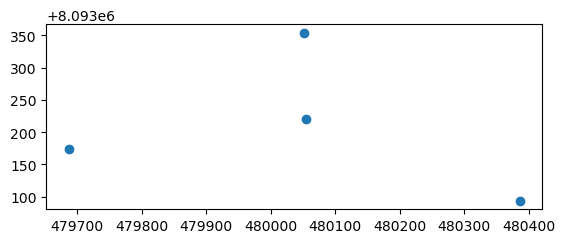

In [248]:
puntos_individuales.loc[[0]].plot()

In [236]:
type(puntos_individuales)

geopandas.geodataframe.GeoDataFrame

In [237]:
siem = gdf_siembras[gdf_siembras['unidad_01'] == '299']
len(siem)

14

<Axes: >

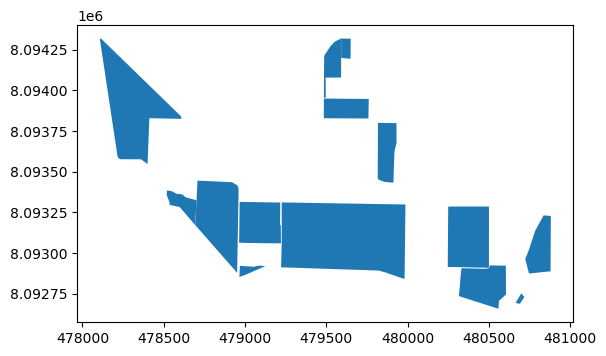

In [238]:
siem.plot()

In [239]:
type(siem)

geopandas.geodataframe.GeoDataFrame

In [240]:
if puntos_individuales.crs != siem.crs:
    print('no')

In [241]:
len(puntos_individuales)

4

In [242]:
gdf_lotes_cat = gpd.sjoin(puntos_individuales, gdf_siembras, how='inner', predicate='intersects')

In [243]:
gdf_lotes_cat

,id_os,geom,cod_ca,nom_ca,obs_left,procesado,producto,dosis,index_right,unidad_01,...,fecha_ini,origen,dias,fecha,prioridad,inst,telefono_1,telefono_2,telefono_3,obs_right
0,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0,754,299,...,None,SIEMBRA 2025,0.0,1899-12-30,0,124.0,0.0,0.0,None,None
0,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0,755,299,...,None,SIEMBRA 2025,0.0,1899-12-30,0,124.0,0.0,0.0,None,None
1,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0,754,299,...,None,SIEMBRA 2025,0.0,1899-12-30,0,124.0,0.0,0.0,None,None
1,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0,755,299,...,None,SIEMBRA 2025,0.0,1899-12-30,0,124.0,0.0,0.0,None,None
2,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0,754,299,...,None,SIEMBRA 2025,0.0,1899-12-30,0,124.0,0.0,0.0,None,None
2,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0,755,299,...,None,SIEMBRA 2025,0.0,1899-12-30,0,124.0,0.0,0.0,None,None
3,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0,754,299,...,None,SIEMBRA 2025,0.0,1899-12-30,0,124.0,0.0,0.0,None,None
3,22,"MULTIPOINT (479687.479 8093173.490, 480051.522...",299,C.I.T.T.C.A.,None,False,crisopa,3.0,755,299,...,None,SIEMBRA 2025,0.0,1899-12-30,0,124.0,0.0,0.0,None,None


In [18]:
for i, row in gdf_puntos.iterrows():
    ors = row['id_os']
    puntos = filtrar_os_y_quitar_caracteres(gdf_puntos, ors)
    multipoint_gdf = puntos.copy()
    puntos_individuales = crear_puntos_individuales(multipoint_gdf)
    
    lotes_solicidud = definir_lotes_solicitud(puntos_individuales)
    lotes_siembra = definir_lotes_siembra(puntos_individuales)

    
    
    # verificar si algun dataframe esta vacio
    dfs = [df for df in [lotes_solicidud, lotes_siembra] if not df.empty]
    # concatena los dfs no vacios
    concat_plan = pd.concat(dfs, axis=0, ignore_index=True)
    
    plan = agregar_campos_faltantes(concat_plan)
    #RECALCULAR EL AREA
    plan['area'] = plan.geometry.area / 10000
    
    plan.rename(columns={'geometry': 'geom'}, inplace=True)
    plan = plan.set_geometry("geom")
    plan['unidad_01'] = plan['unidad_01'].astype(int)
    plan['unidad_03'] = plan['unidad_03'].astype(int)
    plan['dias'] = plan['dias'].astype(int)
    plan['os'] = plan['os'].astype(int)
    plan['soca'] = plan['soca'].astype(int)
    
    
    
    plan['inst'] = plan['inst'].astype(int)
    plan.to_postgis("parte_diario_ctrl_bio", obtener_engine(), schema="drones_control_bio", if_exists="append")
    
    # CARGAR LOTES A AMIGOCLOUD
    plan_os = obtener_parte_diario_por_id_os(ors)
    crear_kmls(plan_os)
    cargar_a_amigocloud(plan_os)
    
    marcar_como_procesado(ors)

G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\KML_PLAN\299
✔️ id_os 18 marcado como procesado.


<Axes: >

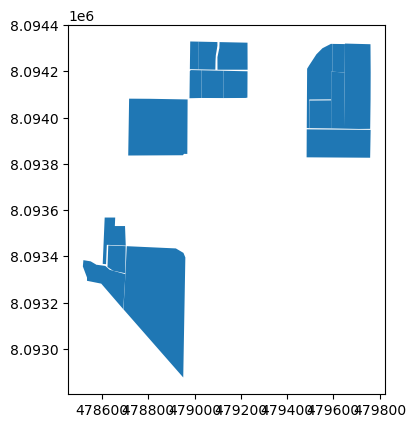

In [30]:
plan_os.plot()